# EE 304 - Neuromorphics: Brains in Silicon

## Temporal Representation

- In the previous lectures, we covered representation of a vector space by a population of neurons
    - We converted a vector $x$ into neural activity values $a_i$, and then converted those back to the original value $\hat{x}$.  
- What happens if $x$ changes over time?  
    - That is, if we have $x(t)$, how do we get $a_i(t)$?
    - Seems pretty easy:
        - $a=G[\alpha e \cdot x + J^{bias}]$, so...
        - $a(t)=G[\alpha e \cdot x(t) + J^{bias}]$
        - where $G[J(t)]= {1 \over {\tau_{ref}-\tau_{RC}ln(1-{1 \over J(t)})}}$

In [1]:
import nengo
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
%matplotlib inline

from nengo.utils.matplotlib import rasterplot
from nengo.dists import Uniform
from nengo.processes import WhiteSignal

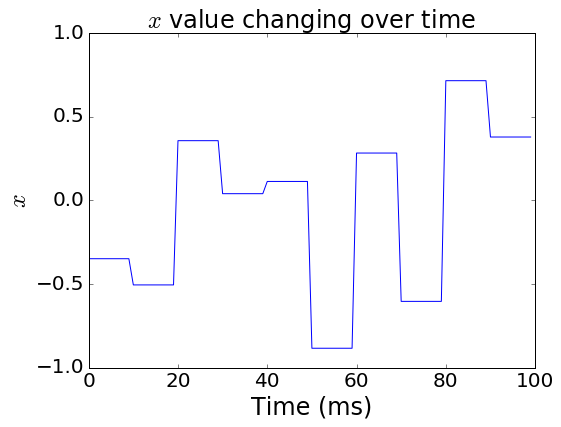

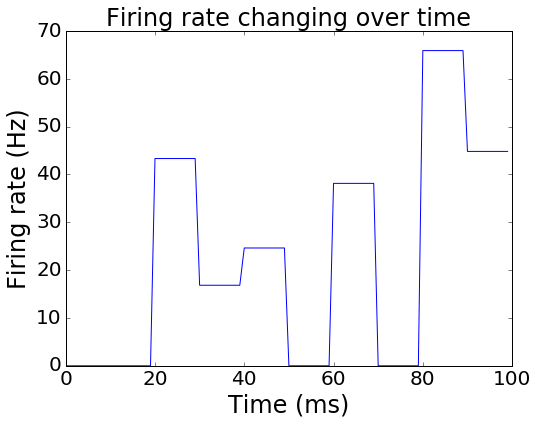

In [2]:
n = nengo.neurons.LIFRate()

x = np.zeros(100)
for i in range(10):
    x[i*10:(i+1)*10]=np.random.uniform(-1,1)

plt.figure(figsize=(8,6))
plt.title('$x$ value changing over time')
plt.plot(x)
plt.ylabel('$x$')
plt.ylim(-1,1)
plt.xlabel('Time (ms)')

plt.figure(figsize=(8,6))
plt.title('Firing rate changing over time')
plt.plot(n.rates(x, gain=1.5, bias=1))
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Time (ms)');

- Unfortunately, that formula for $G[J(t)]$ is an *average* firing rate over a long period of time.
    - What does it mean to be firing at 10Hz for 10ms?
- We need to model what's actually happening to that neuron over time 

## Leaky Integrate-and-Fire neurons

- The simplest neuron model that
    - Produces spikes
    - Uses parameters that correspond to physical properties of real neurons
  
<img src="files/lecture3/neuron.png">

- Bilipid cell membrane acts as a capacitor

- Ion-channels in the cell membrane act as a resistor
    - This is the "leak" current
- Resistance and capacitance together yield a "time-constant"
    - $\tau_{RC}=R C$
- When voltage passes some threshold, a "spike" is emitted
    - Very fast, brief response that's pretty much the same each time
    - Spike at time $t_n$ is modelled as $\delta(t-t_n)$
- Neuron recovers over a short period of time
    - Refractory time $\tau_{ref}$
    - During this time the voltage is reset to some resting level

<img src="files/lecture3/lif.png">

- Typical values for real neurons
    - $\tau_{RC}$: 20 ms
    - $\tau_{ref}$: 2 ms
    - Reset voltage (a.k.a. resting potential): -70mV
    - Firing threshold (a.k.a. threshold potential): -55mV
        - NOTE: we normalize this so that reset is at 0 and firing is at 1
        - This does not affect anything about the behaviour of the model
        
- For lots more info, see Unit 2 in [this online course](http://www.saylor.org/courses/bio303/)

### The LIF RC circuit

<img src="files/lecture3/rc_circuit.png">

### Useful physical laws
- Kirchhoff's Current Law
    - Sum of currents flowing into a node is zero
    - $J_{M} - J_R - J_C = 0 \implies J_{M} = J_R + J_C$
    
- Ohm's Law
    - Current through a resitor is proportional to the voltage across it
    - $ J_R = {V \over R}$
    
- Capacitor Law
    - Charge in a capacitor is proportional to the voltage across it
    - $ Q = C V $
    - Change in these quantities over time gives
        - $ {{dQ} \over {dt}} = C {{dV} \over {dt}} $
    - Rate of change of charge is current
        - $ J_C = C {{dV} \over {dt}} $
 
- Applying these laws to RC circuits:
    - $ J_{M} =  {V \over R} + C {{dV} \over {dt}} $
    - Then solve for change in voltage with input

$$
\begin{align}
{{dV} \over {dt}} &= {1 \over C}(J_{M} - V/R)  \\
 &= {1 \over {RC}}(R J_{M} - {V})  \\
 &= {1 \over {\tau_{RC}}}(R J_{M} - {V}) 
\end{align}
$$

In [ ]:
Got up to here.
Alex's feedback: 

1. When you were explaining the linear decoder, a picture might have been nice (visualize adding tuning curves up to form a line or whatever function, you could do something pretty neat in python). The "neurons voting" thing was kind of misleading.

2. If you're going to go through the entire derivation (which was a nice nice way of doing it, because it didn't rest on any knowledge other than calculus), you should spend a little time clarifying the connection between your result and the "one line of matlab" that people usually write. 

3. I'm not sure how clear the encoding process is at this point. When you show the biological tuning curves, you should put more emphasis on preferred directions (maybe have some biological tuning curve in 2D). Then you can say that encoders are just implementing preferred directions.

### LIF RC Circuit Behavior
- If we solve the general ODE, we get a convolution:

$
\begin{align}
V(t) = \frac{R}{\tau_{RC}} \int_0^t e^{-(t-t')/\tau_{RC}} J_M(t')\; dt'
\end{align}
$

- That is, the voltage right now (at $t$) depends on all past current input, $J_M(t')$, where each input is weighted by a function that decays exponentially with time--the further away (in the past) it is from the current time, the less that input contributes.

- The above result assumes zero initial conditions (i.e., $V(t)=0$ at $t=0$).
- If $J_M$ is constant:

$
\begin{align}
V(t) &= \frac{R J_M}{\tau^{RC}} e^{-t/\tau_{RC}}\int_0^t e^{t'/\tau_{RC}} \; dt' \\
&= J_M R (1-e^{-t/\tau_{RC}}) \end{align}
$

### LIF Interspike Interval
- How long does it take to get to threshold?
    - $ V_{th} = J_MR(1-e^{-t_{th}/\tau_{RC}}) $
    - $ t_{th} = -\tau_{RC} ln (1-{V_{th} \over {J_MR}}) $
 
- How long between spikes?
    - $t_{th} + \tau_{ref}$
    
- Spike rate
    - $a = {1 \over {t_{th} + \tau_{ref}}}$    
    - $a = {1 \over {\tau_{ref}-\tau_{RC}ln(1-{V_{th} \over {J_MR}})}} $

- Simplify by assuming $V_{th}=1$ and $R=1$
    - $a = {1 \over {\tau_{ref}-\tau_{RC}ln(1-{1 \over J_M})}} $    
    - This is the rate if the input current is constant
    
- However, $J_M$ changes over time (since $x(t)$ also changes over time)
- Hence, we need to do the convolution--or solve the ODE numerically
    - $ {{dV} \over {dt}} = {1 \over {\tau_{RC}}} [R J_{input}(t) - {V(t)}]  $

## LIF Model Simulation
- When simulating the LIF neuron, we need to determine times at which the voltage reaches threshold
- At these times, we 'pastes' a spike on the voltage trace and then reset the voltage to zero
    - As opposed to simulating the nonlinear differential equations that describe the spike-generation mechanism

- Let's try a constant input

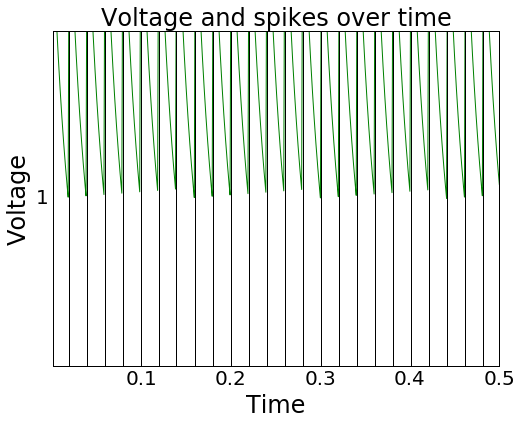

In [3]:
model = nengo.Network(label='Spiking Neurons')

with model:
    stimulus = nengo.Node(0)
    ens = nengo.Ensemble(1, dimensions=1, 
                         encoders = [[1]],
                         intercepts = [-.5],
                         max_rates= [100])
    
    nengo.Connection(stimulus, ens)
    
    spikes_p = nengo.Probe(ens.neurons, 'spikes')
    voltage_p = nengo.Probe(ens.neurons, 'voltage')
    stim_p = nengo.Probe(stimulus)
    
sim = nengo.Simulator(model)
sim.run(.5, progress_bar=False)

t = sim.trange()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(t, sim.data[voltage_p],'g')
plt.ylabel("Voltage")
plt.xlabel("Time")
rasterplot(t, sim.data[spikes_p], ax=ax, colors=['k'])
plt.title('Voltage and spikes over time');

- Let's try a sine wave input

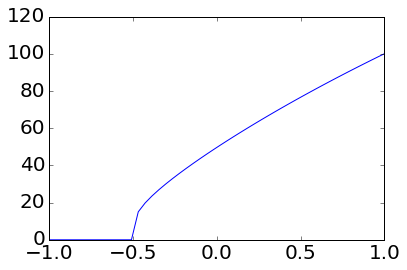

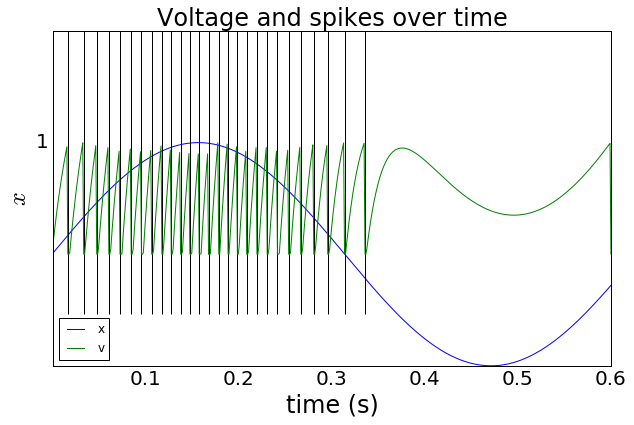

In [4]:
with model:
    stimulus.output = lambda t: np.sin(10*t)
    
sim = nengo.Simulator(model)
sim.run(.6, progress_bar=False)

nengo.utils.matplotlib.plot_tuning_curves(ens, sim)

t = sim.trange()     
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.plot(t, sim.data[stim_p], label='x')
rasterplot(t, sim.data[spikes_p], ax=ax, colors=['k'])
ax.invert_yaxis()
ax.plot(t, sim.data[voltage_p],'g', label='v')
plt.title('Voltage and spikes over time')
plt.ylabel("Voltage");
plt.xlabel("Time");

plt.ylabel('$x$')
plt.ylim(-1,2)
plt.xlabel('time (s)')
plt.legend(loc='lower left');

## Temporal Decoding

- So that's what happens when we allow $x(t)$ to vary over time
    - We set $J(t)=\alpha e \cdot x(t) + J^{bias}$
    - We feed this input to the LIF model's ODE (instead of using $G[J(t)]$)
    - We get out a discrete sequence of spikes (instead of a continous rate $a(t)$) 

- How do decode this spike train?
    - How do we get an estimate of $x$ given that sequence of spikes?

  
### The time vs. rate-coding debate

- There is a long-standing debate in the neuroscience about whether neurons use a "rate" code or a "timing" code
- Rate code
    - The important thing is the firing rate over some window of time (~100ms)
- Time code
    - The *precise* pattern of spike generation carries information
- The NEF gets rid of this distinction
    - The important thing is how long the window of time is
        - Long windows--'slow' decoders--will seem like a rate code
        - Short windows--'fast' decoders--will seem like a time code

### Linear Decoding
<a id="decoders"></a>
- Can we still decode $x$ using a sum of activities?
    - $\hat{x}(t)=\sum_i{a_i(t) d_i}$
    
- Let's use exactly the same technique we did before to find $d$
    - $ d = \Gamma^{-1} \Upsilon $
    - $ \Upsilon_i = \sum_x a_i x dx$
    - $ \Gamma_{ij} = \sum_x a_i a_j dx $
- Let's consider a case with 2 neurons
    - For simplicity, use the same $\alpha$ and $J^{bias}$, but use $e_1=1$ and $e_2=-1$

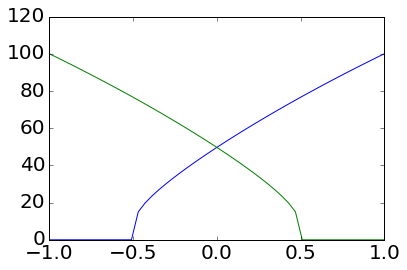

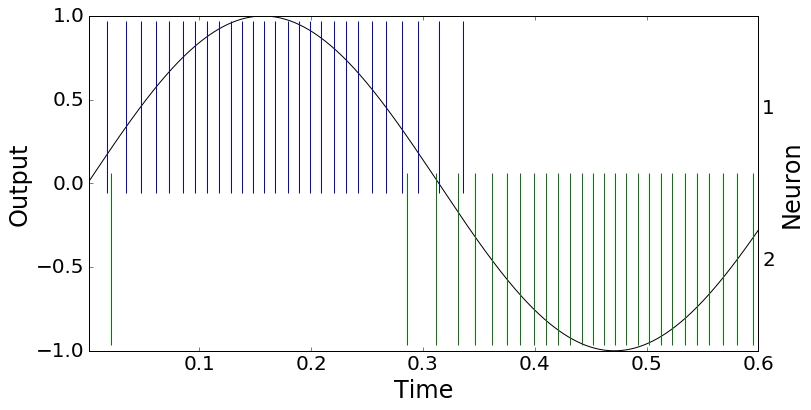

In [5]:
model = nengo.Network(label='Two Neurons')

with model:
    stim = nengo.Node(lambda t: np.sin(10*t))
    ens = nengo.Ensemble(2, dimensions=1,
                         encoders = [[1],[-1]],
                         intercepts = [-.5, -.5],
                         max_rates= [100, 100])
    nengo.Connection(stim, ens)
   
    stim_p = nengo.Probe(stim)
    spikes_p = nengo.Probe(ens.neurons, 'spikes')
   
sim = nengo.Simulator(model)
sim.run(.6, progress_bar=False)

nengo.utils.matplotlib.plot_tuning_curves(ens, sim)

t = sim.trange()
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
plt.plot(t, sim.data[stim_p],'k')
plt.ylabel("Output")
plt.xlabel("Time");
rasterplot(t, sim.data[spikes_p], ax=ax.twinx(), colors=['b', 'g'])
plt.ylabel("Neuron");

- After solving for the decoders and summing, we get:

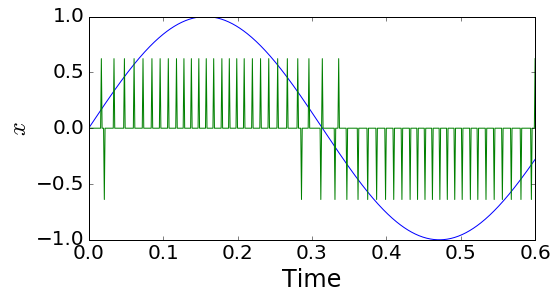

In [6]:
model = nengo.Network(label='Decoding Neurons')

with model:
    stim = nengo.Node(lambda t: np.sin(10*t))
    ens = nengo.Ensemble(2, dimensions=1,
                         encoders = [[1],[-1]],
                         intercepts = [-.5, -.5],
                         max_rates = [100, 100])
    temp = nengo.Ensemble(10, dimensions=1)
    
    nengo.Connection(stim, ens)
    connection = nengo.Connection(ens, temp) #This is just to generate the decoders
   
    stim_p = nengo.Probe(stim)
    spikes_p = nengo.Probe(ens.neurons, 'spikes')
   
sim = nengo.Simulator(model)
sim.run(.6, progress_bar=False)

t = sim.trange()

x = sim.data[stim_p][:,0]

A = sim.data[spikes_p]

gamma=np.dot(A.T,A)
upsilon=np.dot(A.T,x)
d = np.dot(np.linalg.pinv(gamma),upsilon)

xhat = np.dot(A, d)

plt.figure(figsize=(8,4))
plt.plot(t, x, label='x')
plt.plot(t, xhat)
plt.ylabel('$x$')
#plt.ylim(-1,1)
plt.xlabel('Time');

- What if we add more neurons?

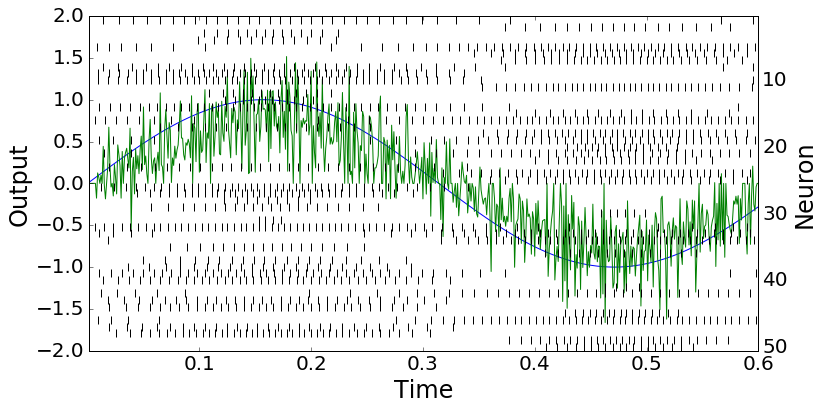

In [7]:
model = nengo.Network(label='Decoding Neurons')

N = 50 

with model:
    stim = nengo.Node(lambda t: np.sin(10*t))
    ens = nengo.Ensemble(N, dimensions=1,
                         max_rates=Uniform(100,200))
    temp = nengo.Ensemble(10, dimensions=1)
    
    nengo.Connection(stim, ens)
    connection = nengo.Connection(ens, temp) #This is just to generate the decoders
   
    stim_p = nengo.Probe(stim)
    spikes_p = nengo.Probe(ens.neurons, 'spikes')
   
sim = nengo.Simulator(model)
sim.run(.6, progress_bar=False)

x = sim.data[stim_p][:,0]

A = sim.data[spikes_p]

gamma=np.dot(A.T,A)
upsilon=np.dot(A.T,x)
d = np.dot(np.linalg.pinv(gamma),upsilon)

xhat = np.dot(A, d)

t = sim.trange()
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
plt.plot(t, sim.data[stim_p],'b')
plt.plot(t, xhat,'g')
plt.ylabel("Output")
plt.xlabel("Time");
rasterplot(t, sim.data[spikes_p], ax=ax.twinx(), colors=['k' for i in xrange(N)])
# axis('tight')
plt.ylabel("Neuron");

- What's happening here?
- At a given instant in time $t$, only a very small number of neurons are firing
    - If no neurons are firing at that instant, $\hat{x}=0$
    - There are usually only one or two neurons firing at any given time
    - As $dt$ gets smaller, the problem gets even worse
- What can we do?    

## Temporal filtering

- We want a spike to contribute to other points in time
- So we want to convert a train of spikes into some continuous function
- Convolution is perfect for this:
    -  $\hat{x}(t)=\sum_i{a_i(t) * h(t) d_i}$
    
- What should we use for $h(t)$?
    - Maybe a gaussian?
    - $h(t) = e^{-t^2 / {2\sigma^2}}$

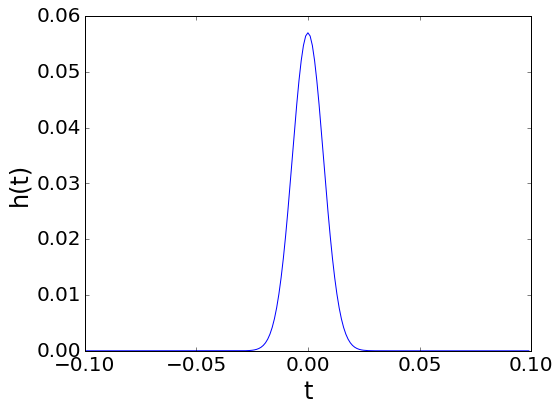

In [8]:
dt = 0.001
sigma = 0.007
t_h = np.arange(200)*dt-0.1
h = np.exp(-t_h**2/(2*sigma**2))
h = h/np.linalg.norm(h,1)

plt.figure(figsize=(8,6))
plt.plot(t_h, h)
plt.xlabel('t')
plt.ylabel('h(t)');

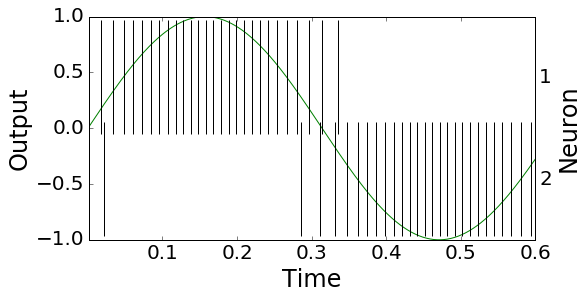

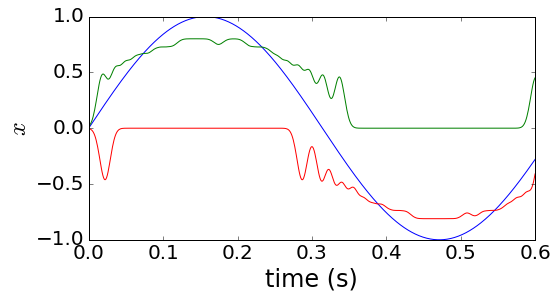

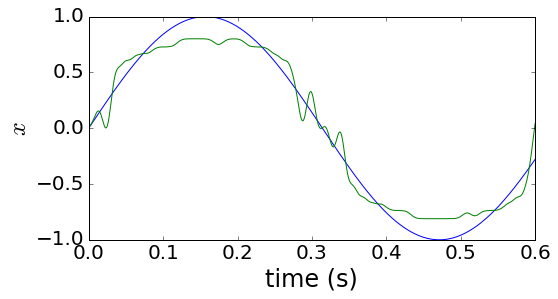

In [9]:
model = nengo.Network(label='Decoding Neurons')
N = 2
with model:
    stim = nengo.Node(lambda t: np.sin(10*t))
    ens = nengo.Ensemble(N, dimensions=1,
                         encoders = [[1],[-1]],
                         intercepts = [-.5, -.5],
                         max_rates = [100, 100])
    temp = nengo.Ensemble(10, dimensions=1)
    
    nengo.Connection(stim, ens)
    connection = nengo.Connection(ens, temp) #This is just to generate the decoders
   
    stim_p = nengo.Probe(stim)
    spikes_p = nengo.Probe(ens.neurons, 'spikes')
   
sim = nengo.Simulator(model)
sim.run(.6, progress_bar=False)

t = sim.trange()
x = sim.data[stim_p]
d = sim.data[connection].weights.T

fspikes1 = np.convolve(sim.data[spikes_p][:,0], h, mode='same')
fspikes2 = np.convolve(sim.data[spikes_p][:,1], h, mode='same')

A = np.array([fspikes1, fspikes2]).T

xhat = np.dot(A, d)

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
plt.plot(t, sim.data[stim_p],'g')
plt.ylabel("Output")
plt.xlabel("Time");
rasterplot(t, sim.data[spikes_p], ax=ax.twinx(), colors=['k' for i in xrange(N)])
plt.ylabel("Neuron")

plt.figure(figsize=(8,4))
plt.plot(t, x, label='x')
plt.plot(t, fspikes1*d[0])
plt.plot(t, fspikes2*d[1])
plt.ylabel('$x$')
plt.xlabel('time (s)')

plt.figure(figsize=(8,4))
plt.plot(t, x, label='x')
plt.plot(t, xhat, label='x')
plt.ylabel('$x$')
plt.xlabel('time (s)');

- Better, but how can we improve this?
    - Different shapes for $h(t)$?
    - Different $\sigma$?
- We want a solution that works in real-time
    - $h(t)$ can't start before the spike arrives (i.e., $h(t)=0$ for $t<0$)
    - Such filters are called causal filters

## Biologically plausible filter

- How do neurons turn incoming spike trains into continuous signals?
- What actually happens when a spike arrives at one of a neuron's synapses?
    - How does the synapse transform the spike?

<img src="files/lecture3/synapse.jpg">

- A spike causes a vesicle to release neurotransmitter
- The neurotransmitter causes ion-channels in the neuron's membrane to open
- Current flows into (or out of) the neuron
- The neurotransmitter is slowly reabsorbed

### Post-synaptic currents
- So the neuron doesn't get spikes as inputs
    - It gets these post-synaptic currents
    
$$
h(t) = \begin{cases}
    e^{-t/\tau} &\mbox{if } t > 0 \\ 
    0 &\mbox{otherwise} 
    \end{cases}
$$

- This is the standard simple model
    - $\tau$ is different for different neurotransmitters and different neurotransmitter receptors
    - GABA-A-R: $\tau=10.41 \pm 6.16$ ms
    - AMPA-type GluR: $\tau=2.2 \pm 0.2$ ms
    - NMDA-type GluR: $\tau=146 \pm 9.1$ ms

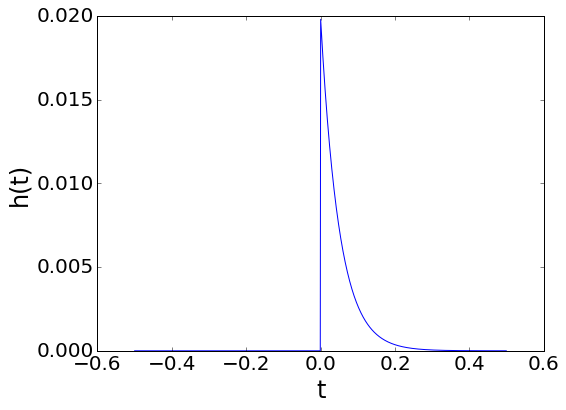

In [10]:
dt = 0.001
tau = 0.05
t_h = np.arange(1000)*dt-0.5
h = np.exp(-t_h/tau)
h[np.where(t_h<0)]=0
h = h/np.linalg.norm(h,1)

plt.figure(figsize=(8,6))
plt.plot(t_h, h)
plt.xlabel('t')
plt.ylabel('h(t)');

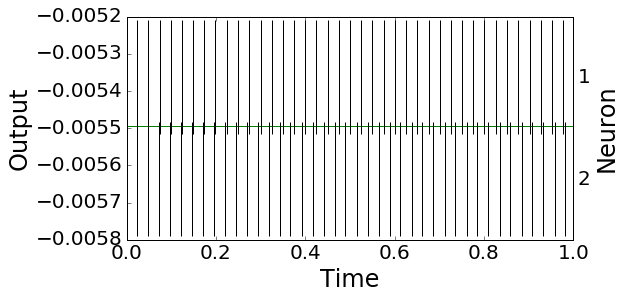

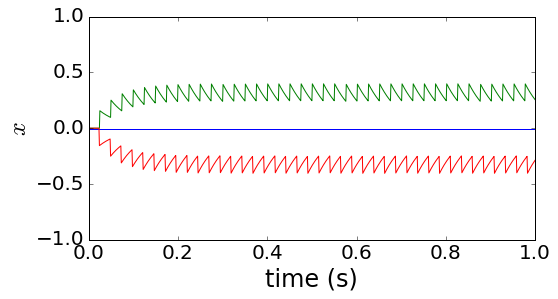

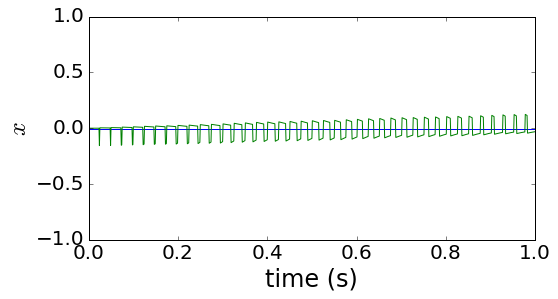

In [11]:
T=1.0
dt=0.001
tau = 0.05

t_h = np.arange(1000)*dt-0.5
h = np.exp(-t_h/tau)
h[np.where(t_h<0)]=0
h = h/np.linalg.norm(h,1)

samples = np.arange(T/dt)
max_freq=10
stim = WhiteSignal(period=T, high=max_freq, rms=0.5)
step = stim.make_step((0,), samples.shape, dt, rng=np.random.RandomState(3))
sig = np.array([step(t) for t in samples])[:,0]

def stim_fcn(t): #function to input signal
    idx = int(t/dt)
    if idx>=1000: idx=999
    return sig[idx]

model = nengo.Network()
with model:
    in_stim = nengo.Node(stim_fcn)
    ens = nengo.Ensemble(2, dimensions=1,
                         encoders = [[1],[-1]],
                         intercepts = [-.3, -.3],
                         max_rates= [100, 100])
    temp = nengo.Ensemble(1, dimensions=1)

    nengo.Connection(in_stim, ens)
    connection = nengo.Connection(ens, temp) #This is just to generate the decoders
   
    stim_p = nengo.Probe(in_stim)
    spikes_p = nengo.Probe(ens.neurons, 'spikes')
    dec_p = nengo.Probe(ens)

samples = np.arange(T/dt)
max_freq=10
stim = WhiteSignal(period=T, high=max_freq, rms=0.5)
step = stim.make_step((0,), samples.shape, dt, rng=np.random.RandomState(3))
sig = np.array([step(t) for t in samples])[:,0]

sim = nengo.Simulator(model)
sim.run(T, progress_bar=False)

fspikes1 = np.convolve(sim.data[spikes_p][:,0], h, mode='same')
fspikes2 = np.convolve(sim.data[spikes_p][:,1], h, mode='same')

A = np.array([fspikes1, fspikes2]).T

d = sim.data[connection].weights.T

xhat = np.dot(A, d)

t = sim.trange()

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
plt.plot(t, sig,'g')
plt.ylabel("Output")
plt.xlabel("Time");
rasterplot(t, sim.data[spikes_p], ax=ax.twinx(), colors=['k' for i in xrange(N)])
plt.ylabel("Neuron")

plt.figure(figsize=(8,4))
plt.plot(t, sig, label='x')
plt.plot(t, fspikes1*d[0])
plt.plot(t, fspikes2*d[1])
plt.ylabel('$x$')
plt.ylim(-1,1)
plt.xlabel('time (s)')

plt.figure(figsize=(8,4))
plt.plot(t, sig, label='x')
plt.plot(t, xhat, label='x')
plt.ylabel('$x$')
plt.ylim(-1,1)
plt.xlabel('time (s)');

- What about with more neurons?

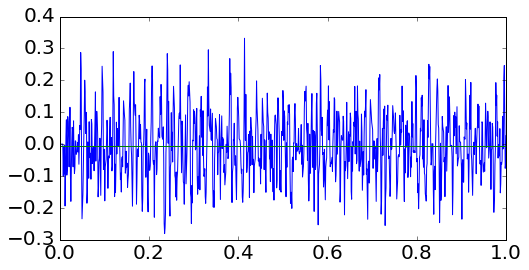

In [12]:
with model:
    ens = nengo.Ensemble(40, dimensions=1, max_rates=Uniform(100,200))

    nengo.Connection(in_stim, ens)

    dec_p = nengo.Probe(ens, synapse = 0.005)
    
sim = nengo.Simulator(model)
sim.run(T, progress_bar=False)

t = sim.trange()
plt.figure(figsize=(8,4))
plt.plot(t,sim.data[dec_p])
plt.plot(t,sig);

- What about different neurotransmitter time constants $\tau$? 

## A detail

- Notice that we find our decoders in two different ways
    - [Here](#decoders) we found them using activities directly
    - With Nengo, we just computed decoders using the non-spiking version of the neurons
    - Then run the model with spikes, filter the data with $h(t)$ and decode
    - You could filter all the spikes first and then invert the resulting A matrix

- Why does this work?
- Consider a single neuron with a constant $x$
    - When we found decoders using a rate mode, the firing rate was $a$
    - When we use spikes, we get $a(t)$, which is a sequence of $0$s and $1$s
    - If the rate neuron is a good model of the spiking neuron, then the firing rate (the sum of $a(t)$ divided by the total time) should approach $a$
- But what about $h(t)$?
    - It should just blur $a(t)$, pushing it towards this average
    - But this will only happen if $\int_{-\infty}^{\infty} h(t)dt=1$ 
    - Otherwise $h(t)$ will scale the value as well
- So this trick only works if we normalize $h(t)$
    
- The filtered spiking neuron model adds variability around the ideal $a$ value
    - This can be treated as noise
    - We can find the variance of this noise (covered in two weeks; see Appendix C.1)
    - Thus this method ensures that the decoders are robust to noise
    - The previous (tuning curve) method can be modified to account for noise (called regularization; covered in a week) 